In [291]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchtext.transforms as T
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.text import build_vocab
from torchlake.text_classification.models import Dcnn
from torchlake.common.utils.platform import get_file_size
from torchtext.data.utils import get_tokenizer

# setting


In [292]:
data_path = Path("../../data/covid-tweet")
artifacts_path = Path("../../artifacts/dcnn")

In [293]:
batch_size = 128
CONTEXT = NlpContext()

# data

In [294]:
train_data = pd.read_csv(
    data_path.joinpath("Corona_NLP_train.csv").as_posix(),
    encoding='latin-1',
    usecols=['OriginalTweet', 'Sentiment'],
)

In [295]:
train_data.query("Sentiment == 'Neutral'")

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
7,Was at the supermarket today. Didn't buy toile...,Neutral
10,All month there hasn't been crowding in the su...,Neutral
16,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,Neutral
17,@eyeonthearctic 16MAR20 Russia consumer survei...,Neutral
...,...,...
41141,#Coronavirus ?? ????? ??? ????? ?? ??? ???????...,Neutral
41143,https://t.co/8s4vKvcO1r #5gtowers?? #EcuadorUn...,Neutral
41144,@_Sunrise_SV @Gamzap @NPR What does not having...,Neutral
41152,Airline pilots offering to stock supermarket s...,Neutral


In [296]:
test_data = pd.read_csv(
    data_path.joinpath("Corona_NLP_test.csv").as_posix(),
    encoding='latin-1',
    usecols=['OriginalTweet', 'Sentiment'],
)

In [297]:
train_data['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [298]:
train_data["OriginalTweet"] = train_data["OriginalTweet"].str.replace("\@.*\s", "", regex=True)

In [299]:
tokenizer = get_tokenizer('basic_english')

In [300]:
vocab = build_vocab(
    train_data["OriginalTweet"].apply(lambda x: tokenizer(x)).tolist(),
    context=CONTEXT,
)

In [301]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = train_data['Sentiment'].nunique()

In [302]:
train_data['OriginalTweet'] = train_data['OriginalTweet'].str.lower()
test_data['OriginalTweet'] = test_data['OriginalTweet'].str.lower()

In [303]:
label_encoder = LabelEncoder()
train_data['Sentiment'] = label_encoder.fit_transform(train_data['Sentiment'])

In [304]:
test_data['Sentiment'] = label_encoder.transform(test_data['Sentiment'])

In [305]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [306]:
def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for text, label in batch:
        text = tokenizer(text)
        text = text_transform(text)
        text_placeholder.append(text)
        label_placeholder.append(label)

    return [torch.stack(text_placeholder), torch.Tensor(label_placeholder)]

In [307]:
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
)

In [308]:
for text, label in train_iter:
    print(text.shape)
    print(label.shape)
    break

torch.Size([128, 256])
torch.Size([128])


d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\_jit_internal.py:1355: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn(


# model


In [309]:
DEVICE = torch.device(CONTEXT.device)

In [310]:
model = Dcnn(
    VOCAB_SIZE,
    embed_dim=300,
    output_size=NUM_CLASS,
    kernels=(14, 10, 6),
    hidden_dims=(32, 64, 128),
    topk=10,
    context=CONTEXT,
).to(DEVICE)

In [311]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
Dcnn                                          --
├─Embedding: 1-1                              3,207,000
├─Sequential: 1-2                             --
│    └─Block: 2-1                             32
│    │    └─Sequential: 3-1                   134,432
│    │    └─Tanh: 3-2                         --
│    └─Block: 2-2                             64
│    │    └─Sequential: 3-3                   20,544
│    │    └─Tanh: 3-4                         --
│    └─Dropout: 2-3                           --
│    └─WideConv1d: 2-4                        --
│    │    └─Conv1d: 3-5                       49,280
│    └─Folding: 2-5                           --
│    └─KmaxPool1d: 2-6                        --
├─Sequential: 1-3                             --
│    └─FlattenFeature: 2-7                    --
│    │    └─Sequential: 3-6                   --
│    └─Linear: 2-8                            3,205
Total params: 3,414,557
Trainable params:

# train


In [312]:
EPOCHES = 20

In [313]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [314]:
criterion = trainer.get_criterion(NUM_CLASS, ignore_index=CONTEXT.padding_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [315]:
training_loss = trainer.run(train_iter, model, optimizer, criterion)

100%|██████████| 321/321 [00:08<00:00, 35.88it/s]


epoch 1 : 0.009625775785971654


100%|██████████| 321/321 [00:09<00:00, 34.21it/s]


epoch 2 : 0.007423693420092729


100%|██████████| 321/321 [00:09<00:00, 35.25it/s]


epoch 3 : 0.005964349103783986


100%|██████████| 321/321 [00:10<00:00, 31.22it/s]


epoch 4 : 0.004967746076774653


100%|██████████| 321/321 [00:10<00:00, 31.90it/s]


epoch 5 : 0.004338194282487546


100%|██████████| 321/321 [00:09<00:00, 33.64it/s]


epoch 6 : 0.0038253732527551063


100%|██████████| 321/321 [00:09<00:00, 33.31it/s]


epoch 7 : 0.003486077887270124


100%|██████████| 321/321 [00:09<00:00, 35.43it/s]


epoch 8 : 0.003204887983464633


100%|██████████| 321/321 [00:09<00:00, 33.81it/s]


epoch 9 : 0.0029426903084552964


100%|██████████| 321/321 [00:09<00:00, 32.61it/s]


epoch 10 : 0.0027297040570173356


100%|██████████| 321/321 [00:09<00:00, 32.79it/s]


epoch 11 : 0.0026088897871416397


100%|██████████| 321/321 [00:08<00:00, 36.08it/s]


epoch 12 : 0.0023924454196568032


100%|██████████| 321/321 [00:08<00:00, 37.65it/s]


epoch 13 : 0.002304723546506599


100%|██████████| 321/321 [00:10<00:00, 30.26it/s]


epoch 14 : 0.002227832873299648


100%|██████████| 321/321 [00:08<00:00, 36.05it/s]


epoch 15 : 0.002158140646862417


100%|██████████| 321/321 [00:08<00:00, 36.34it/s]


epoch 16 : 0.002068062221872217


100%|██████████| 321/321 [00:08<00:00, 37.09it/s]


epoch 17 : 0.0019849377573319823


100%|██████████| 321/321 [00:08<00:00, 37.14it/s]


epoch 18 : 0.0019867795726612233


100%|██████████| 321/321 [00:08<00:00, 36.62it/s]


epoch 19 : 0.0018593925492028558


100%|██████████| 321/321 [00:09<00:00, 33.84it/s]

epoch 20 : 0.0018240464368916329


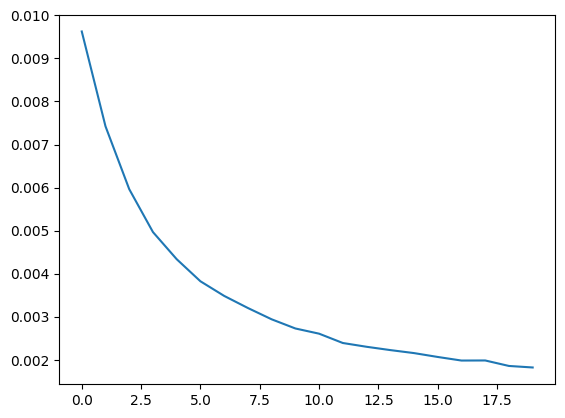

In [316]:
plt.plot(training_loss)

# inference


In [317]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [318]:
test_confusion_matrix = evaluator.run(test_iter, model)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 33.50it/s]

[[400   1 167   0  24]
 [  3 357  17   0 222]
 [120  13 707   0 201]
 [  2   7 301   0 309]
 [  6  85 184   0 672]]


In [319]:
per_class_accs = evaluator.get_per_class_accuracy(test_confusion_matrix)
evaluator.show_per_class_accuracy(label_encoder.classes_, per_class_accs.round(4))

Extremely Negative: 0.6757
Extremely Positive: 0.596
Negative  : 0.6792
Neutral   : 0.0
Positive  : 0.7096


In [320]:
per_class_accs.mean()

0.5320865898727474

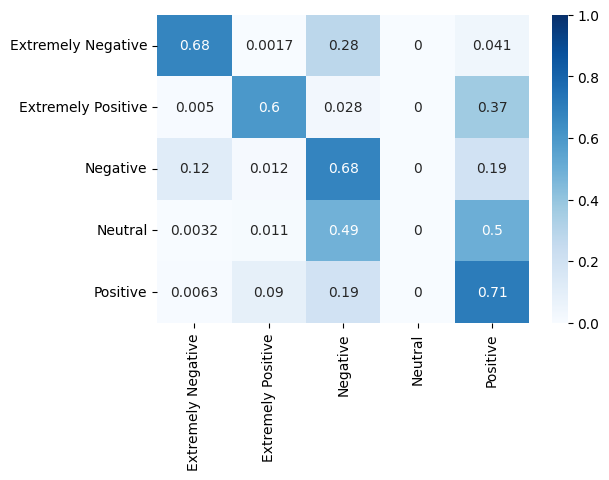

In [321]:
evaluator.plot_confusion_matrix(
    test_confusion_matrix,
    label_encoder.classes_,
    cmap="Blues",
    figsize=(6, 4),
)

In [322]:
model_path = artifacts_path.joinpath("dcnn.pth")

In [323]:
torch.save(model.state_dict(), model_path)

In [324]:
get_file_size(model_path.as_posix())

'13.03MB'

In [325]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>